In [ ]:
!pip install tensorflow_text

In [ ]:
import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

use_builtins = True

In [ ]:
class ShapeChecker():
  def __init__(self):
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')
    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]
      if (broadcast and new_dim == 1):
        continue
      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
file = open('anuvaad.txt','r')
fileStrings = file.readlines()
targ = []
inp = []
for line in fileStrings:
    line = line.replace('\n','')
    lstO = line.split('\t')
    targ.append(lstO[0])
    inp.append(lstO[1])
print(targ)
print(inp)

['Come on boys, it is time to shine.', 'This heart asks for more!', 'She was roasting the spices when the phone rang', 'You know me right', 'I will handle that', 'Come over to my place, we will sit together and drink tea', 'this is a sample', 'I hope I have made you understand well', 'Why is it late? What is your excuse?', 'I get milk for free', 'yes there it is', 'dude I made a mistake', 'Oh do not you know Hinglish? Wait, I will teach you', 'You naughty boy, I will teach you a lesson', 'How are you? I hope everything is going well.', 'Bring some fruits and vegetables', '17 Ways to Increase WordPress Site Speed', 'she only keeps doing timepass', 'we are going to visit tomorrow', 'See you tomorrow afternoon at 3pm', "I am going to visit Shobha, Ravi's would be", 'she is completely filmy', "At the time of the bride's farewell, there was a complete filmy atmosphere.", "Today's movie was just a time-pass.", 'Tell me your number', 'Punit is absolutely an useless man', 'Seema, you are looki

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Nope' b'OkPassing kitne ka he.!' b'DSA 2019' b'Abe chup'
 b'voh mera intezaar kar rahi hain'], shape=(5,), dtype=string)

tf.Tensor(
[b'No.' b'Okay, what is the passing?' b'DSA 2019' b'Hey shutup'
 b'she is waiting for me'], shape=(5,), dtype=string)


In [ ]:
example_text = tf.constant('Yahi haal hai')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Yahi haal hai'
b'Yahi haal hai'


In [ ]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Yahi haal hai
[START] yahi haal hai [END]


In [ ]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(    
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
input_text_processor.adapt(inp)    

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]
# Hinglish TextVectorization layer

['', '[UNK]', '[START]', '[END]', 'hai', '.', '?', 'hain', ',', 'kya']

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]
# English TextVectorization layer

['', '[UNK]', '[START]', '[END]', '.', 'the', 'is', 'i', ',', 'you']

In [ ]:
# the above layers convert a batch of strings into a batch of token IDs
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  792,    3,    0,    0,    0,    0,    0,    0,    0],
       [   2, 1409,  179,   14, 1754,    5,   10,    3,    0,    0],
       [   2,  224,    3,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
# get_vocabulary - converts token IDs back to text
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] nope [END]                   '

In [ ]:
# defining constants for the model
embedding_dim = 256
units = 1024

Encoding

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,embedding_dim) #converts tokens to vectors

    self.gru = tf.keras.layers.GRU(self.enc_units,return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')#processes vectors sequentially.

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    vectors = self.embedding(tokens)#check embedding for each token
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    vectors = self.rnn(tokens)
    shape_checker(x, 'batch s units')

    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))
    return output, state

In [ ]:
example_tokens = input_text_processor(example_input_batch)#i/p to tokens

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 1024)
Encoder state, shape (batch, units): (64, 1024)


Attention layer

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
# creating BahdanauAttention layer
attention_layer = BahdanauAttention(units)

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 22)


In [ ]:
attention_weights.shape

TensorShape([64, 2, 22])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True, recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,use_bias=False)

    # For step 5. This fully connected layer produces the logits for each output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
def call(self, inputs: DecoderInput,state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention( query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  # [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(inputs = DecoderInput(new_tokens=first_token,enc_output=example_enc_output, mask=(example_tokens != 0)),state = example_enc_state)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 1215)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
# sample token according to logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
# decode the token as first word of o/p
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['tutorial'],
       ['semi'],
       ['to'],
       ['market'],
       ['marks']], dtype='<U15')

In [ ]:
# decoder generates second set of logits
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,example_enc_output,mask=(example_tokens != 0)),state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['function'],
       ['morning'],
       ['open'],
       ['lr'],
       ['semester']], dtype='<U15')

Training

In [ ]:
# Loss function definition
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Masking off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    return tf.reduce_sum(loss)

In [ ]:
# implementing training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units, input_text_processor, output_text_processor, use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
# Receiving batches of english & hinglish data
# Converting those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks(certain timesteps in an input are missing).
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
# training
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
# executes the decoder and calculates the incremental loss and new decoder state 
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,enc_output=enc_output, mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
# testing the training step
translator = TrainTranslator(embedding_dim, units,input_text_processor=input_text_processor,output_text_processor=output_text_processor, use_tf_function=False)

# Configure the loss and optimizer
translator.compile(optimizer=tf.optimizers.Adam(),loss=MaskedLoss(),)

In [ ]:
# maximizing performance while training
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),  tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1495695>}

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9923327>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9184628>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8732133>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.847394>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8402793>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8025892>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7349072>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6778128>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.625969>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5785184>}

CPU times: user 7.28 s, sys: 817 ms, total: 8.1 s
Wall time: 5.37 s


....................................................................................................


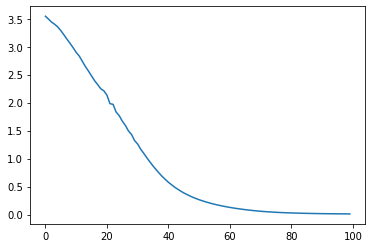

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
# building a fresh copy of the model to train from scratch since the training step is working
train_translator = TrainTranslator(embedding_dim, units,input_text_processor=input_text_processor, output_text_processor=output_text_processor)
train_translator.compile(optimizer=tf.optimizers.Adam(), loss=MaskedLoss(),)

Training the model

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=100, callbacks=[batch_loss])

Epoch 1/100
21/21 [==============================] - 19s 559ms/step - batch_loss: 5.9550
Epoch 2/100
21/21 [==============================] - 12s 547ms/step - batch_loss: 4.7471
Epoch 3/100
21/21 [==============================] - 11s 539ms/step - batch_loss: 4.4406
Epoch 4/100
21/21 [==============================] - 11s 535ms/step - batch_loss: 4.1583
Epoch 5/100
21/21 [==============================] - 11s 541ms/step - batch_loss: 3.7771
Epoch 6/100
21/21 [==============================] - 11s 547ms/step - batch_loss: 3.3884
Epoch 7/100
21/21 [==============================] - 11s 539ms/step - batch_loss: 2.9542
Epoch 8/100
21/21 [==============================] - 12s 551ms/step - batch_loss: 2.5952
Epoch 9/100
21/21 [==============================] - 11s 541ms/step - batch_loss: 2.2092
Epoch 10/100
21/21 [==============================] - 12s 559ms/step - batch_loss: 1.8373
Epoch 11/100
21/21 [==============================] - 12s 580ms/step - batch_loss: 1.4684
Epoch 12/100
21/21 